In [454]:
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Read in data and filter on political subreddits

In [455]:
# load the data
df = pd.read_csv("data/filtered_network.csv")

In [456]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,libertarian,conservative,1uf53xs,2014-01-04 14:41:05,1,"739.0,633.0,0.794316644114,0.00135317997294,0...."
1,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0...."
2,mensrightsmeta,mensrights,1urzs0s,2014-01-15 11:33:58,1,"559.0,471.0,0.75313059034,0.00357781753131,0.0..."
3,politicaldiscussion,politics,1vgz6fs,2014-01-17 11:48:58,1,"582.0,499.0,0.790378006873,0.00687285223368,0...."
4,communism101,socialism,1vi0kys,2014-01-17 13:25:07,1,"2073.0,1792.0,0.766039556199,0.0284611673903,0..."
...,...,...,...,...,...,...
1882,thedavidpakmanshow,socialism,67lc3us,2017-04-25 18:40:37,1,"1316.0,1103.0,0.807750759878,0.00227963525836,..."
1883,shitliberalssay,ukpolitics,67ptug,2017-04-26 10:39:02,-1,"238.0,220.0,0.773109243697,0.0168067226891,0.0..."
1884,enough_sanders_spam,enoughsandersspam,67zs07,2017-04-27 17:34:00,-1,"783.0,681.0,0.757343550447,0.0204342273308,0.0..."
1885,neoliberal,badeconomics,680xo6s,2017-04-27 21:36:40,1,"1506.0,1309.0,0.750332005312,0.0152722443559,0..."


In [457]:
# Create the adjacency matrix from the filtered DataFrame
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.Graph(),edge_attr="count")

#### Plot the graph

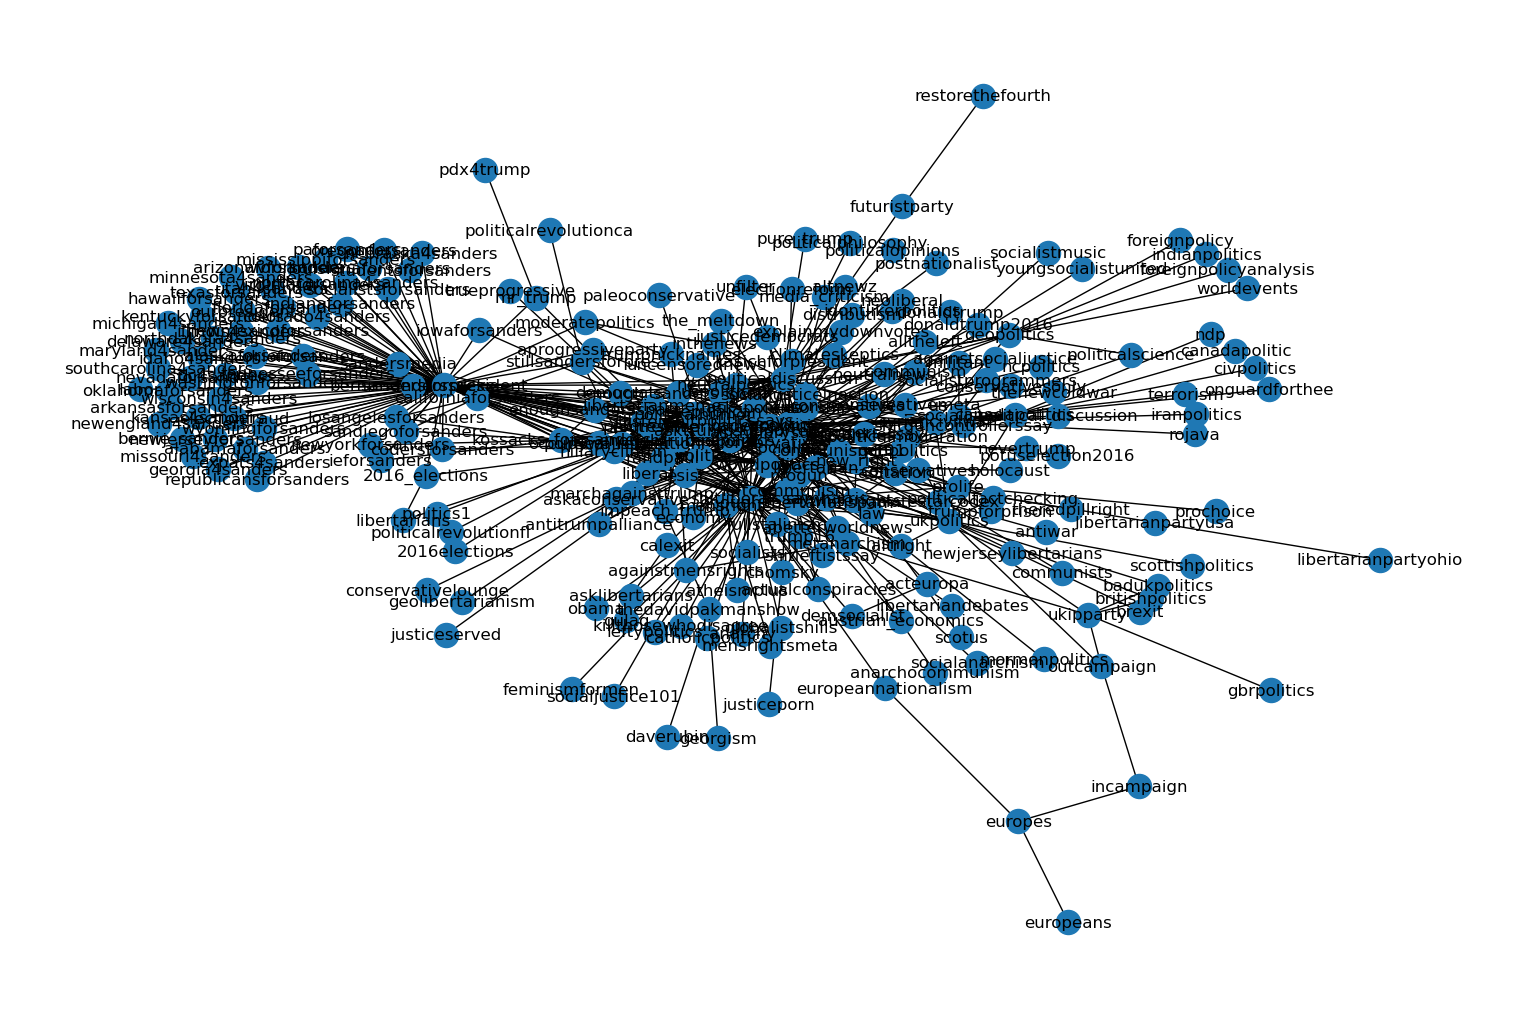

In [458]:
plt.figure(figsize=(15,10))
nx.draw(G, with_labels=True)
plt.show()

In [459]:
# get adjacency matrix
adj_matrix =  nx.to_pandas_adjacency(G, weight='count')

print("Adjacency Matrix:")
adj_matrix

Adjacency Matrix:


,libertarian,conservative,communism101,communism,mensrightsmeta,mensrights,politicaldiscussion,politics,socialism,postnationalist,...,esist,socialjustice101,globalistshills,conservativelounge,daverubin,neoliberal,theredpillright,holocaust,bernie_sanders,georgism
libertarian,0.0,6.0,0.0,0.0,0.0,1.0,3.0,16.0,9.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
conservative,6.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
communism101,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
communism,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mensrightsmeta,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
neoliberal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
theredpillright,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
holocaust,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bernie_sanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [460]:
degree_matrix = np.diag(adj_matrix.sum(axis=1))
d_max = np.max(np.diag(degree_matrix))
delta_values = [0.01, 0.05, 0.1, 0.5, 1]
laplacians = []
for delta in delta_values:
    d_max = np.max(degree_matrix)
    ridge_regularization = degree_matrix + delta * d_max * np.eye(adj_matrix.shape[0])
    sqrt_inv = np.linalg.inv(np.sqrt(ridge_regularization))
    laplacian_prime = sqrt_inv @ adj_matrix @ sqrt_inv
    laplacians.append(laplacian_prime)

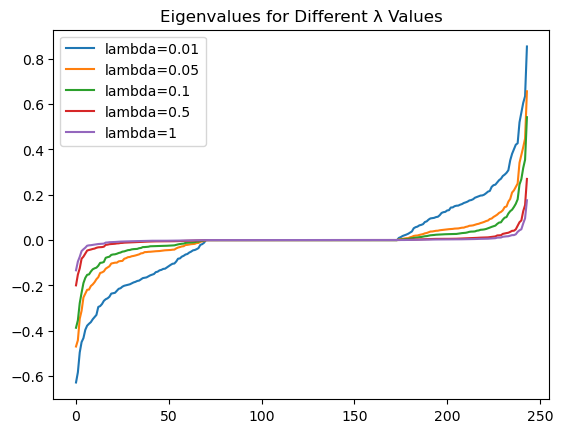

In [461]:
for i, laplacian in enumerate(laplacians):
    eigenvalues, _ = np.linalg.eigh(laplacian)
    plt.plot(eigenvalues, label=f'lambda={delta_values[i]}')
plt.legend()
plt.title('Eigenvalues for Different λ Values')
plt.show()

## Perform SCORE+ community detection

In [462]:
# Inputs
delta = 0.05  # Ridge regularization parameter
t = 0.10  # Signal weakness threshold
K = 6 # Initial number of clusters

#### Step 1: Pre-PCA Normalization with Laplacian

In [463]:
n = adj_matrix.shape[0]
D = np.diag(adj_matrix.sum(axis=1)) 
d_max = np.max(np.diag(D)) 
ridge_regularization = D + delta * d_max * np.eye(n)
sqrt_inv = np.linalg.inv(np.sqrt(ridge_regularization))
L_delta = sqrt_inv @ adj_matrix @ sqrt_inv

#### Step 2: PCA and Signal Weakness Test

In [464]:
eigenvalues, eigenvectors = np.linalg.eigh(L_delta)
sorted_indices = np.argsort(eigenvalues)[::-1] 
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Signal weakness test
if eigenvalues[K] / eigenvalues[K - 1] <= t:
    M = K + 1
else:
    M = K

print("Number of clusters:", M)

Number of clusters: 6


#### Step 3: Post-PCA Normalization

In [465]:
R_hat = []
epsilon = 1e-9  

eta_1 = eigenvalues[0] * eigenvectors[:, 0]

for k in range(1, M):
    eta_k = eigenvalues[k] * eigenvectors[:, k] 
    normalized_eta_k = eta_k / (eta_1 + epsilon)
    R_hat.append(normalized_eta_k)

R_hat = np.column_stack(R_hat)

#### Step 4: Clustering on the rows of R_hat

In [466]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(R_hat)
labels = kmeans.labels_

print("Number of clusters:", K)

# Compute silhouette score and inerita
silhouette_avg = silhouette_score(R_hat, labels)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_avg}")
print(f"Inertia: {inertia}")

Number of clusters: 6
Silhouette Score: 0.5460119554018856
Inertia: 317.89361963554313


In [467]:
# Create a dictionary to store cluster labels
clustered_subreddits = pd.DataFrame({
    "Subreddit": adj_matrix.index,
    "Cluster": labels 
})

clusters_dict = defaultdict(list)

for subreddit, cluster in zip(adj_matrix.index, labels): 
    clusters_dict[cluster].append(subreddit)

# Print subreddits in each cluster
for cluster_id, subreddits in sorted(clusters_dict.items()):
    print(f"Cluster {cluster_id}: {subreddits}")
    print(f"Number of subreddits: {len(subreddits)}\n")  

Cluster 0: ['sandersforpresident', 'nevadaforsanders', 'wvforsanders', 'illinois4sanders', 'labor', 'californiaforsanders', 'minnesota4sanders', 'delaware4sanders', 'tennesseeforsanders', 'newjerseyforsanders', 'codersforsanders', 'texasforsanders', 'iowaforsanders', 'virginiaforsanders', 'washingtonforsanders', 'oregonforsanders', 'utah4sanders', 'oklahomaforsanders', 'michigan4sanders', 'wisconsin4sanders', 'arizonaforsanders', 'kansas4sanders', 'nebraska4sanders', 'indianaforsanders', 'northcarolina4sanders', 'alabamaforsanders', 'kentuckyforsanders', 'arkansasforsanders', 'newyorkforsanders', 'ohioforsanders', 'losangelesforsanders', 'maryland4sanders', 'paforsanders', 'alaskaforsanders', 'expats4sanders', 'dc4sanders', 'missouri4sanders', 'berniesanderssucks', 'socialistsforsanders', 'colorado4sanders', 'newengland4sanders', 'floridaforsanders', 'georgia4sanders', 'hawaiiforsanders', 'idaho4sanders', 'louisianaforsanders', 'mississippiforsanders', 'newmexicoforsanders', 'northdako

### Plot 2D PCA, 2D TSNE and 3D PCA

Principal Component 1: 35.51% variance explained
Principal Component 2: 23.77% variance explained
Total Variance Explained by PCA: 59.29%


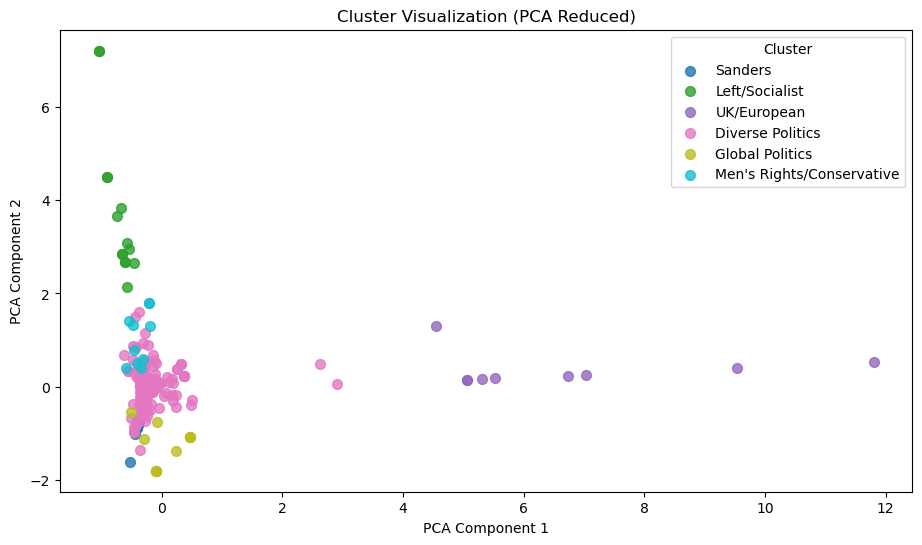

In [487]:
# Reduce to 2 dimensions using PCA and plot
cluster_names = [
    "Sanders",
    "Left/Socialist",
    "UK/European",
    "Diverse Politics",
    "Global Politics",
    "Men's Rights/Conservative"
]

pca = PCA(n_components=2)
R_hat_2d = pca.fit_transform(R_hat) 

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Convert to percentage
explained_variance_percentage = explained_variance_ratio * 100

# Print the percentage of variance explained by each component
for i, percentage in enumerate(explained_variance_percentage):
    print(f"Principal Component {i+1}: {percentage:.2f}% variance explained")

# Total variance explained by the selected components
total_variance_explained = sum(explained_variance_percentage)
print(f"Total Variance Explained by PCA: {total_variance_explained:.2f}%")

colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_names)))

# Create PCA scatter plot
plt.figure(figsize=(11, 6))

# Plot each cluster with its color
for cluster_id, cluster_name in enumerate(cluster_names):
    cluster_points = R_hat_2d[labels == cluster_id]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1], 
        label=cluster_name, 
        s=50, 
        alpha=0.8, 
        color=colors[cluster_id]
    )

# Add legend
plt.legend(title="Cluster", loc='upper right')
plt.title('Cluster Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

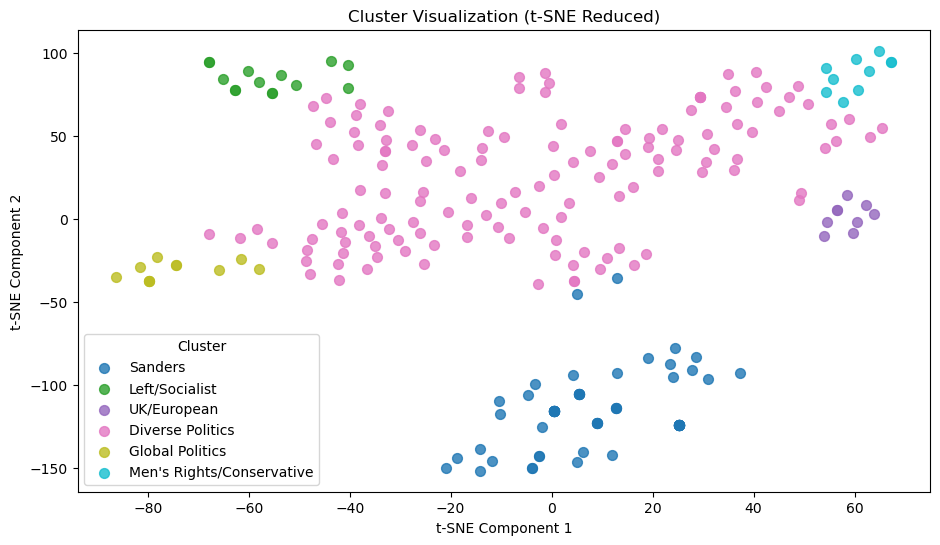

In [488]:
# Reduce to 2 dimensions using TSNE and plot
tsne = TSNE(n_components=2, random_state=0)
R_hat_2d_tsne = tsne.fit_transform(R_hat)

# Create t-SNE scatter plot
plt.figure(figsize=(11, 6))

# Plot each cluster with its color and add a legend
for cluster_id, cluster_name in enumerate(cluster_names):
    cluster_points = R_hat_2d_tsne[labels == cluster_id]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1], 
        label=cluster_name, 
        s=50, 
        alpha=0.8, 
        color=colors[cluster_id]
    )

# Add legend
plt.legend(title="Cluster", loc='lower left')
plt.title('Cluster Visualization (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Principal Component 1: 35.51% variance explained
Principal Component 2: 23.77% variance explained
Principal Component 3: 19.33% variance explained
Total Variance Explained in 3D PCA: 78.61%


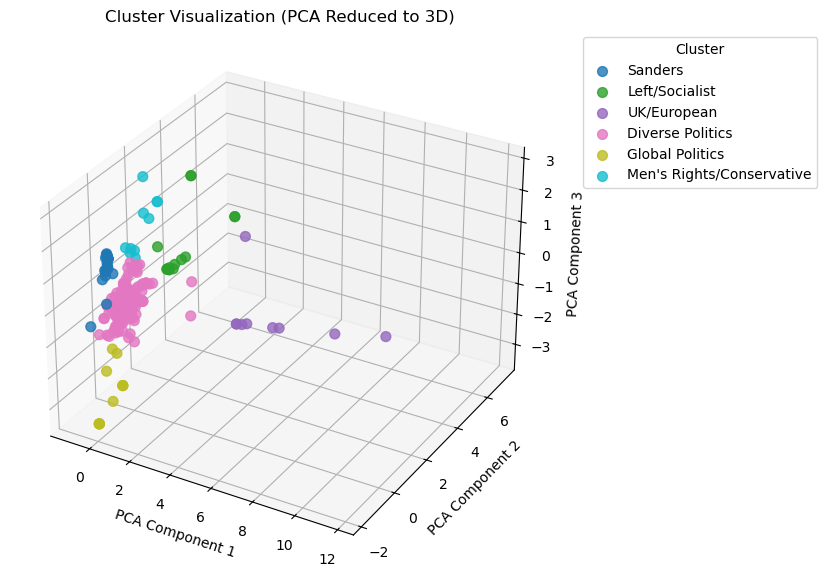

In [489]:
# Reduce to 3 dimensions using PCA
pca_3d = PCA(n_components=3)
R_hat_3d = pca_3d.fit_transform(R_hat)

explained_variance_ratio = pca_3d.explained_variance_ratio_
explained_variance_percentage = explained_variance_ratio * 100

# Print variance explained
for i, percentage in enumerate(explained_variance_percentage):
    print(f"Principal Component {i+1}: {percentage:.2f}% variance explained")

# Total variance explained by the 3D projection
total_variance_explained = sum(explained_variance_percentage)
print(f"Total Variance Explained in 3D PCA: {total_variance_explained:.2f}%")

# Create 3D plot
# Create 3D plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with its color and add legend labels
for cluster_id, cluster_name in enumerate(cluster_names):
    cluster_points = R_hat_3d[labels == cluster_id]
    ax.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1], 
        cluster_points[:, 2], 
        label=cluster_name, 
        s=50, 
        alpha=0.8, 
        color=colors[cluster_id]
    )

# Add legend
ax.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_title('Cluster Visualization (PCA Reduced to 3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

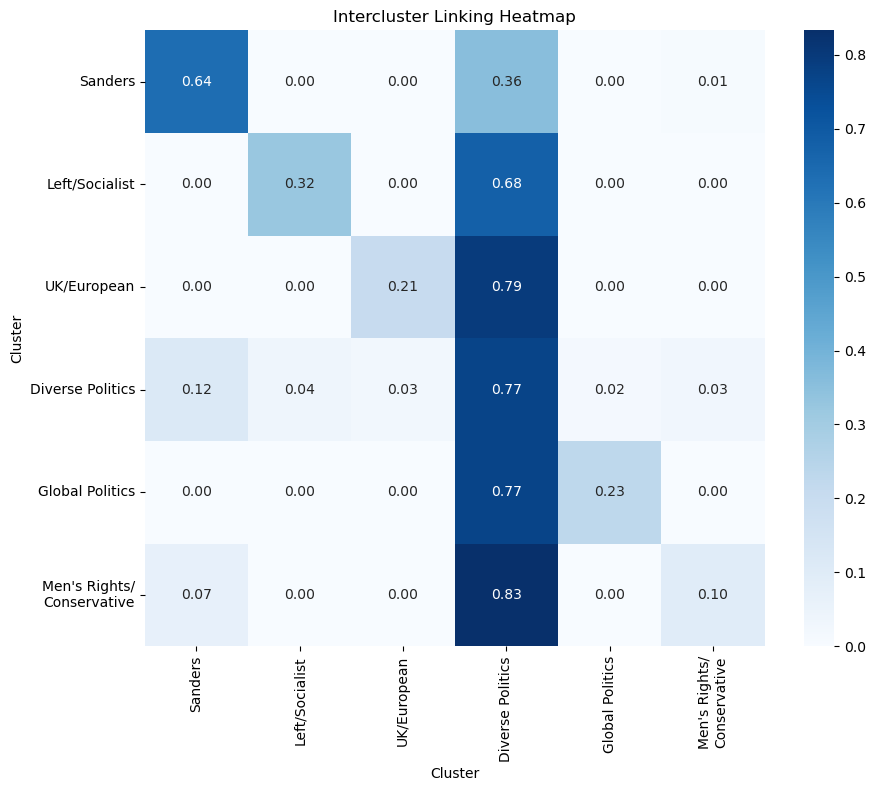

In [471]:
import seaborn as sns
num_clusters = len(set(labels))
intercluster_matrix = np.zeros((num_clusters, num_clusters))

# Create a dictionary of node to cluster mapping
node_to_cluster = {node: labels[idx] for idx, node in enumerate(G.nodes())}

# Iterate through edges to compute intercluster links
for node1, node2, attr in G.edges(data=True):
    cluster1 = node_to_cluster[node1]
    cluster2 = node_to_cluster[node2]
    weight = attr.get('count', 1)  # Use the 'count' attribute as weight, default to 1
    intercluster_matrix[cluster1, cluster2] += weight
    if cluster1 != cluster2:
        intercluster_matrix[cluster2, cluster1] += weight  # Symmetric matrix for undirected graphs

# Normalize the matrix (optional, if clusters are of different sizes)
normalized_matrix = intercluster_matrix / intercluster_matrix.sum(axis=1, keepdims=True)

cluster_labels = [
    "Sanders",
    "Left/Socialist",
    "UK/European",
    "Diverse Politics",
    "Global Politics",
    "Men's Rights/\nConservative"
]

# Create a heatmap with custom tick labels
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=cluster_labels, yticklabels=cluster_labels)
plt.title("Intercluster Linking Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.xticks(rotation=90)  # Rotate x-tick labels for better readability
plt.yticks(rotation=0) 
plt.show()

In [491]:
print(normalized_matrix)

[[0.63612565 0.         0.         0.35602094 0.         0.0078534 ]
 [0.         0.32258065 0.         0.67741935 0.         0.        ]
 [0.         0.         0.20512821 0.79487179 0.         0.        ]
 [0.11908932 0.03677758 0.02714536 0.76882662 0.01751313 0.03064799]
 [0.         0.         0.         0.76923077 0.23076923 0.        ]
 [0.07142857 0.         0.         0.83333333 0.         0.0952381 ]]


In [472]:
print(labels)

[3 3 1 1 5 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 4 5 3 3 3
 3 3 2 3 3 3 5 5 5 3 3 3 5 1 3 3 2 5 3 3 2 3 0 3 3 3 3 3 2 3 4 3 5 2 0 3 3
 3 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0
 0 0 1 3 3 3 3 0 0 3 3 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3 0 3 3 3 3 4 3 0 4 0 3
 3 3 1 3 2 4 1 5 3 3 3 3 3 0 3 3 3 3 3 3 0 2 3 1 3 3 0 3 3 3 3 3 3 3 4 3 3
 3 3 3 3 3 2 3 3 3 3 0 3 3 0 3 3 3 3 3 3 3 3 3 3 4 4 3 4 3 3 3 3 3 0 1 3 1
 3 3 3 1 3 4 3 3 3 3 3 3 3 5 3 3 1 3 3 3 0 1]
